### import necessary libraries


In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set the path to the dataset
dataset_path="D:\Multi-class DD using CNN\Brain_tumor\dataset"

#training and testing directories
train_dir = os.path.join(dataset_path,"D:\Multi-class DD using CNN\Brain_tumor\dataset\Training")
test_dir = os.path.join(dataset_path,"D:\Multi-class DD using CNN\Brain_tumor\dataset\Testing")

In [3]:
# Define categories (adjust based on your dataset)
categories = os.listdir(train_dir)
print("Categories:", categories)

Categories: ['glioma', 'meningioma', 'notumor', 'pituitary']


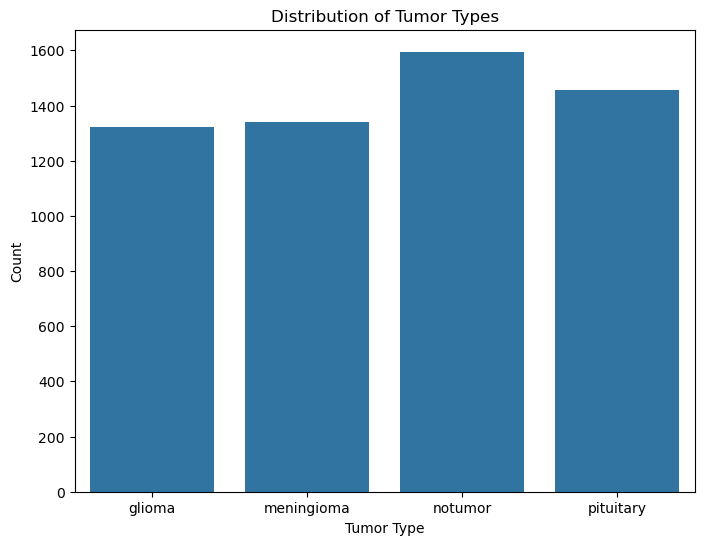

In [4]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

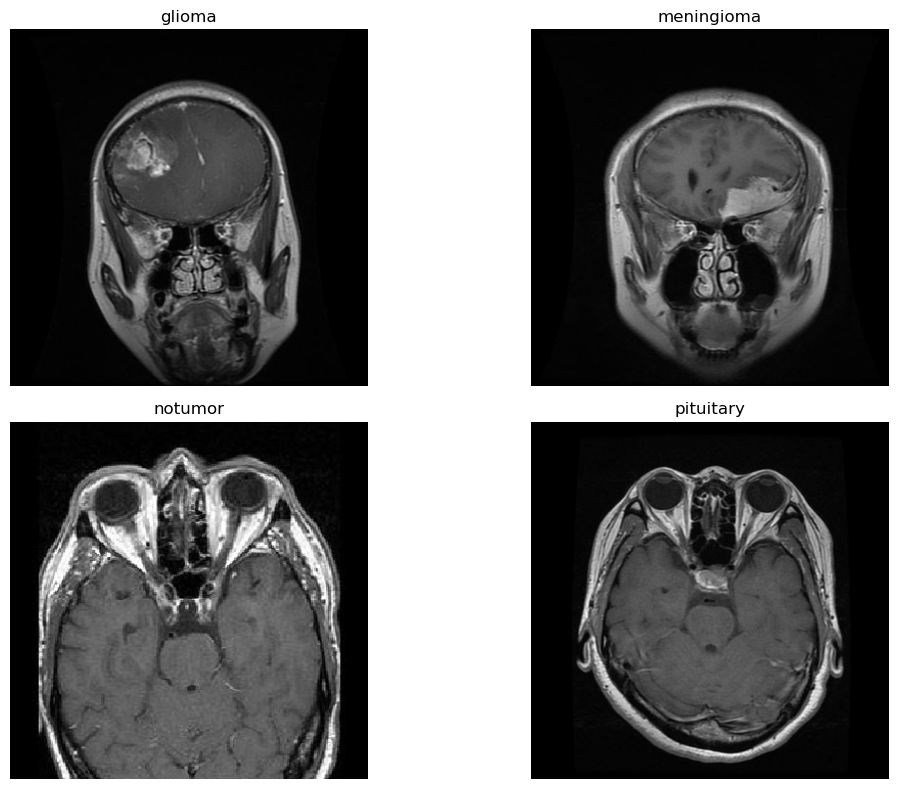

In [5]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Adjust based on number of disease classes
])

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,398,148 (169.37 MB)

 Trainable params: 44,398,148 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Data Augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [10]:
# Validation data should only be rescaled
val_datagen = ImageDataGenerator(rescale=1.0/255)


In [11]:
# Load datasets
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')

val_data = val_datagen.flow_from_directory(test_dir,
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='categorical')


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [12]:
# Train the model
history = model.fit(train_data, epochs=50, validation_data=val_data)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 484s 3s/step - accuracy: 0.3336 - loss: 1.5635 - val_accuracy: 0.4973 - val_loss: 1.1744
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 468s 3s/step - accuracy: 0.5640 - loss: 0.9633 - val_accuracy: 0.5355 - val_loss: 1.1799
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 477s 3s/step - accuracy: 0.6718 - loss: 0.8094 - val_accuracy: 0.6438 - val_loss: 0.8858
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step - accuracy: 0.6949 - loss: 0.7573 - val_accuracy: 0.6751 - val_loss: 0.8395
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 477s 3s/step - accuracy: 0.7115 - loss: 0.7288 - val_accuracy: 0.6232 - val_loss: 1.0294
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.7218 - loss: 0.6885 - val_accuracy: 0.6895 - val_loss: 0.8108
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 599s 3s/step - accuracy: 0.7406 - loss: 0.6608 - val_accuracy: 0.5889 - val_loss: 1.0140
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 473s 3s/step - accuracy: 0.7472 - loss: 0.6289 - val_accu

In [ ]:
# Save the model
model.save('brain_tumor_cnn_model.keras')

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 539ms/step - accuracy: 0.8478 - loss: 0.3969
Validation Accuracy: 83.75%
Validation Loss: 0.4200


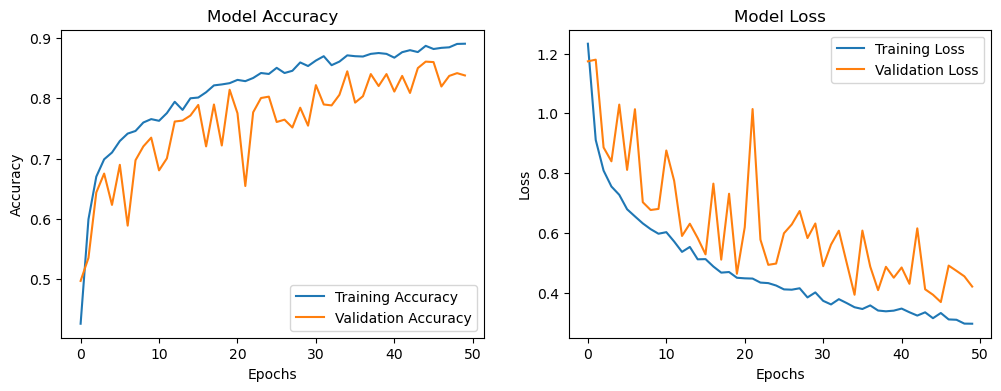

In [15]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
# Compile the model (use the same optimizer, loss, and metrics as during training)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(val_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 485ms/step - accuracy: 0.8372 - loss: 0.4215
Test Accuracy: 83.75%
Test Loss: 0.4200


In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(val_data)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 511ms/step - accuracy: 0.8449 - loss: 0.4369
Test Loss: 0.41997331380844116
Test Accuracy: 0.8375285863876343


In [20]:
from tensorflow.keras.preprocessing import image

img_path = r'D:\Multi-class DD using CNN\Brain_tumor\dataset\Training\glioma\Tr-gl_0011.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
predicted_class = categories[np.argmax(predictions[0])]
print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
Predicted Class: pituitary


41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 486ms/step


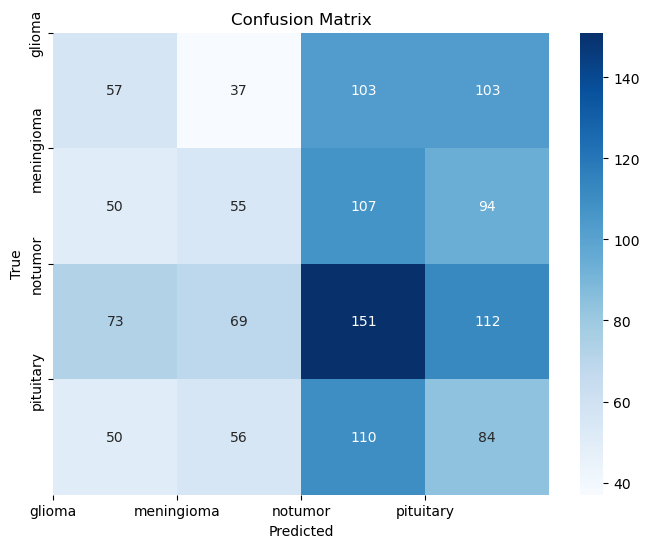

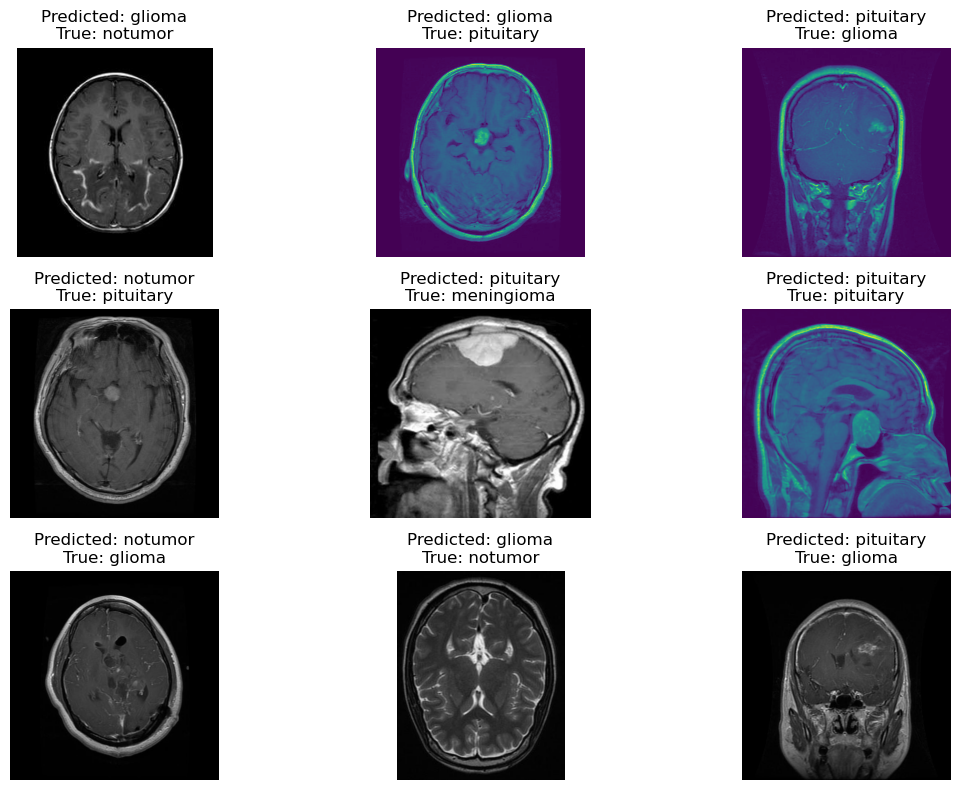

In [21]:
# Make predictions on the test dataset
predictions = model.predict(val_data)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = val_data.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Plot sample images with their predicted and true labels
test_images = val_data.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import classification_report

# Get true labels from the test data generator
true_labels = val_data.classes

# Get predicted probabilities from the model
predictions = model.predict(val_data)
predicted_labels = np.argmax(predictions, axis=1)

# Ensure target names match the categories (classes)
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=categories))


41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 462ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.24      0.18      0.21       300
  meningioma       0.23      0.16      0.19       306
     notumor       0.32      0.38      0.35       405
   pituitary       0.22      0.29      0.25       300

    accuracy                           0.26      1311
   macro avg       0.25      0.25      0.25      1311
weighted avg       0.26      0.26      0.26      1311



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting — stops training if val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate if validation loss plateaus — reduces by half after 3 stagnant epochs
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model with callbacks
history = model.fit(
    train_data,
    epochs=50,  # You can set a high number since early stopping will prevent unnecessary training
    validation_data=val_data,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the best model
model.save('brain_tumor_cnn_model.keras')
